In [ ]:
!pip3 install sentence-transformers nltk tf-keras

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from keras.optimizers import Adam
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')


try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    print("Downloading VADER lexicon...")
    nltk.download('vader_lexicon')
    print("Download complete.")

def analyze_sentiment(text_series):
    """Analyze sentiment of text data."""
    sia = SentimentIntensityAnalyzer()
    # Handle potential non-string values
    sentiments = text_series.fillna("").apply(lambda x: sia.polarity_scores(str(x))['compound'])
    return sentiments

def create_sequences_recursive(data, sequence_length, target_col_index):
    """Create sequences for LSTM input - Recursive Forecasting."""
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])
        y.append(data[i, target_col_index])
    return np.array(X), np.array(y)

def create_sequences_multioutput(data, sequence_length, target_col_index, forecast_horizon=5):
    """Create sequences for LSTM input - Multi-output Prediction."""
    X, y = [], []
    for i in range(sequence_length, len(data) - forecast_horizon + 1):
        X.append(data[i - sequence_length:i])
        y.append(data[i:i + forecast_horizon, target_col_index])
    return np.array(X), np.array(y)

def build_lstm_model_recursive(input_shape, lstm_units=[50, 50, 50], dropout_rate=0.2, learning_rate=0.001):
    """Build LSTM model for Recursive Forecasting."""
    model = Sequential()
    # First LSTM layer
    model.add(LSTM(units=lstm_units[0], return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    # Additional LSTM layers
    for units in lstm_units[1:-1]:
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    # Final LSTM layer
    model.add(LSTM(units=lstm_units[-1]))
    model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(units=1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def build_lstm_model_multioutput(input_shape, forecast_horizon, lstm_units=[50, 50, 50], dropout_rate=0.2, learning_rate=0.001):
    """Build LSTM model for Multi-output Prediction."""
    model = Sequential()
    # First LSTM layer
    model.add(LSTM(units=lstm_units[0], return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    # Additional LSTM layers
    for units in lstm_units[1:-1]:
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    # Final LSTM layer
    model.add(LSTM(units=lstm_units[-1]))
    model.add(Dropout(dropout_rate))
    # Repeat vector and time distributed layers for multi-output
    model.add(RepeatVector(forecast_horizon))
    model.add(LSTM(units=lstm_units[-1], return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(TimeDistributed(Dense(1)))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def recursive_predict(model, X_test, target_scaler, steps_ahead=5):
    """Generate recursive predictions for multiple steps ahead."""
    predictions = []
    current_input = X_test[0].copy()  # Start with the first test sequence
    
    for _ in range(min(steps_ahead, len(X_test))):
        # Predict next value
        pred = model.predict(current_input.reshape(1, *current_input.shape), verbose=0)
        predictions.append(pred[0, 0])
        
        # Update input sequence by shifting and adding new prediction
        # This assumes the target is the last feature in the sequence
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, -1] = pred[0, 0]  # Assuming target is last feature
    
    return np.array(predictions)

def train_and_evaluate_recursive(model, X_train, y_train, X_test, y_test, target_scaler, model_name, epochs=25, batch_size=32):
    """Train model and evaluate performance for Recursive Forecasting."""
    print(f"\nTraining {model_name} (Recursive)...")
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_split=0.1, verbose=0)

    predictions = model.predict(X_test, verbose=0)
    predictions = target_scaler.inverse_transform(predictions)
    y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mse = mean_squared_error(y_test_actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, predictions)
    da = directional_accuracy(y_test_actual.flatten(), predictions.flatten())

    return predictions, y_test_actual, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'DA': da}, history

def train_and_evaluate_multioutput(model, X_train, y_train, X_test, y_test, target_scaler, model_name, epochs=25, batch_size=32):
    """Train model and evaluate performance for Multi-output Prediction."""
    print(f"\nTraining {model_name} (Multi-output)...")
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_split=0.1, verbose=0)

    predictions = model.predict(X_test, verbose=0)
    # For multi-output, we take the first prediction of each sequence for comparison
    first_predictions = predictions[:, 0].reshape(-1, 1)
    first_predictions = target_scaler.inverse_transform(first_predictions)
    y_test_actual = target_scaler.inverse_transform(y_test[:, 0].reshape(-1, 1))
    
    mse = mean_squared_error(y_test_actual, first_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, first_predictions)
    da = directional_accuracy(y_test_actual.flatten(), first_predictions.flatten())

    return first_predictions, y_test_actual, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'DA': da}, history

def directional_accuracy(y_true, y_pred):
    """Calculate directional accuracy."""
    y_true_direction = np.diff(y_true) > 0
    y_pred_direction = np.diff(y_pred) > 0
    return accuracy_score(y_true_direction, y_pred_direction)

def plot_training_history(history, model_name):
    """Plot training and validation loss."""
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def merge_data(df1, df2, output_file):
    df1 = pd.read_csv(df1)
    df2 = pd.read_csv(df2)

    merged = pd.merge(df2, df1, on='Date', how='inner')

    top_columns = [f'Top{i}' for i in range(1, 26)]

    merged['text'] = merged[top_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    top_columns.append('High')
    top_columns.append('Low')
    top_columns.append('Vol.')
    top_columns.append('Change %')

    merged = merged.drop(top_columns, axis=1)

    merged['Open'] = pd.to_numeric(merged['Open'].astype(str).str.replace(',', ''))
    merged['Close'] = pd.to_numeric(merged['Close'].astype(str).str.replace(',', ''))

    merged.to_csv(f'merged_{output_file}.csv', index=False)



In [30]:

merge_data('XAU_USD.csv', 'WorldNewsData.csv', 'XAU_USD')
# Load data
df = pd.read_csv('merged_XAU_USD.csv')
title = "Gold" 

# Basic data info
print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:", df.columns.tolist())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing text data for sentiment analysis
df['text'] = df['text'].fillna("")


Data shape: (1324, 4)

First few rows:
           Date     Open    Close  \
0  May 01, 2018  1303.97  1315.58   
1  May 02, 2018  1304.85  1304.38   
2  May 03, 2018  1312.09  1305.18   
3  May 04, 2018  1315.05  1312.30   
4  May 07, 2018  1314.30  1315.03   

                                                text  
0  North Korea to open its sky, South Korean medi...  
1  'What have they got to fear? ' Trump threatens...  
2  Hollywood isn’t simply churning out crummy rem...  
3  Donald Trump says London hospital is 'like a w...  
4  Over 26,000 people have crossed the border int...  

Column names: ['Date', 'Open', 'Close', 'text']

Missing values:
Date     0
Open     0
Close    0
text     0
dtype: int64


# Analyze sentiment


In [18]:
print("\nAnalyzing sentiment...")
df['sentiment_compound'] = analyze_sentiment(df['text'])
print("Sample of data with sentiment:")
print(df[['Date', 'text', 'sentiment_compound']].head())



Analyzing sentiment...
Sample of data with sentiment:
           Date                                               text  \
0  May 01, 2018  North Korea to open its sky, South Korean medi...   
1  May 02, 2018  'What have they got to fear? ' Trump threatens...   
2  May 03, 2018  Hollywood isn’t simply churning out crummy rem...   
3  May 04, 2018  Donald Trump says London hospital is 'like a w...   
4  May 07, 2018  Over 26,000 people have crossed the border int...   

   sentiment_compound  
0              0.6800  
1             -0.6393  
2             -0.8661  
3              0.9857  
4             -0.4497  


# Generate sentence embeddings


In [19]:
print("\nGenerating sentence embeddings...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(df['text'].tolist(), show_progress_bar=True)
embedding_df = pd.DataFrame(embeddings).add_prefix('embedding_')
df_with_embeddings = pd.concat([df.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)
print("Embeddings added. New shape:", df_with_embeddings.shape)



Generating sentence embeddings...


Batches: 100%|██████████| 42/42 [00:11<00:00,  3.72it/s]

Embeddings added. New shape: (1324, 389)


# Initialize storage for results


In [20]:
recursive_results = {}
recursive_predictions = {}
multioutput_results = {}
multioutput_predictions = {}

y_test_actual_recursive = None
y_test_actual_multioutput = None

sequence_length = 60
forecast_horizon = 5 

target_col = 'Close'
feature_sets = {
    "No Embedding": ['Open', 'Close'],
    "With Embedding": [f'embedding_{i}' for i in range(embeddings.shape[1])] + ['Open', 'Close'],
    "With Sentiment": ['sentiment_compound', 'Open', 'Close']
}

scalers = {} 


# Train and test Recursive Forecasting models


In [21]:
for model_name, features in feature_sets.items():
    print(f"\n--- Recursive Model {len(recursive_results)+1}: {model_name} ---")
    
    # Select data
    if model_name == "With Embedding":
        data = df_with_embeddings[features].copy()
    else:
        data = df[features].copy()
    
    # Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    scalers[f"recursive_{model_name}"] = scaler
    
    # Target scaler (only for target column)
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler.fit(data[[target_col]].values)
    
    # Create sequences for recursive forecasting

    target_col_index = data.columns.get_loc(target_col)

        
    X, y = create_sequences_recursive(scaled_data, sequence_length, target_col_index)
    
    # Split data
    train_size = int(len(X) - 270)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Set common actual values for plotting
    if y_test_actual_recursive is None:
        y_test_actual_recursive = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Build and train model
    model = build_lstm_model_recursive((X_train.shape[1], X_train.shape[2]))
    predictions, y_actual, metrics, history = train_and_evaluate_recursive(
        model, X_train, y_train, X_test, y_test, target_scaler, f"Recursive {model_name}"
    )
    
    # Store results
    recursive_results[model_name] = metrics
    recursive_predictions[model_name] = predictions.flatten()




--- Recursive Model 1: No Embedding ---

Training Recursive No Embedding (Recursive)...

--- Recursive Model 2: With Embedding ---

Training Recursive With Embedding (Recursive)...

--- Recursive Model 3: With Sentiment ---

Training Recursive With Sentiment (Recursive)...


# Train and test Multi-output Prediction models


In [22]:
for model_name, features in feature_sets.items():
    print(f"\n--- Multi-output Model {len(multioutput_results)+1}: {model_name} ---")
    
    # Select data
    if model_name == "With Embedding":
        data = df_with_embeddings[features].copy()
    else:
        data = df[features].copy()
    
    # Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    scalers[f"multioutput_{model_name}"] = scaler
    
    # Target scaler (only for target column)
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler.fit(data[[target_col]].values)
    
    # Create sequences for multi-output prediction
    target_col_index = data.columns.get_loc(target_col)
 
        
    X, y = create_sequences_multioutput(scaled_data, sequence_length, target_col_index, forecast_horizon)
    
    # Split data
    train_size = int(len(X) - 270)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Set common actual values for plotting
    if y_test_actual_multioutput is None:
        y_test_actual_multioutput = target_scaler.inverse_transform(y_test[:, 0].reshape(-1, 1)).flatten()
    
    # Build and train model
    model = build_lstm_model_multioutput((X_train.shape[1], X_train.shape[2]), forecast_horizon)
    predictions, y_actual, metrics, history = train_and_evaluate_multioutput(
        model, X_train, y_train, X_test, y_test, target_scaler, f"Multi-output {model_name}"
    )
    
    # Store results
    multioutput_results[model_name] = metrics
    multioutput_predictions[model_name] = predictions.flatten()



--- Multi-output Model 1: No Embedding ---

Training Multi-output No Embedding (Multi-output)...

--- Multi-output Model 2: With Embedding ---

Training Multi-output With Embedding (Multi-output)...

--- Multi-output Model 3: With Sentiment ---

Training Multi-output With Sentiment (Multi-output)...


# Visualization for Recursive Forecasting


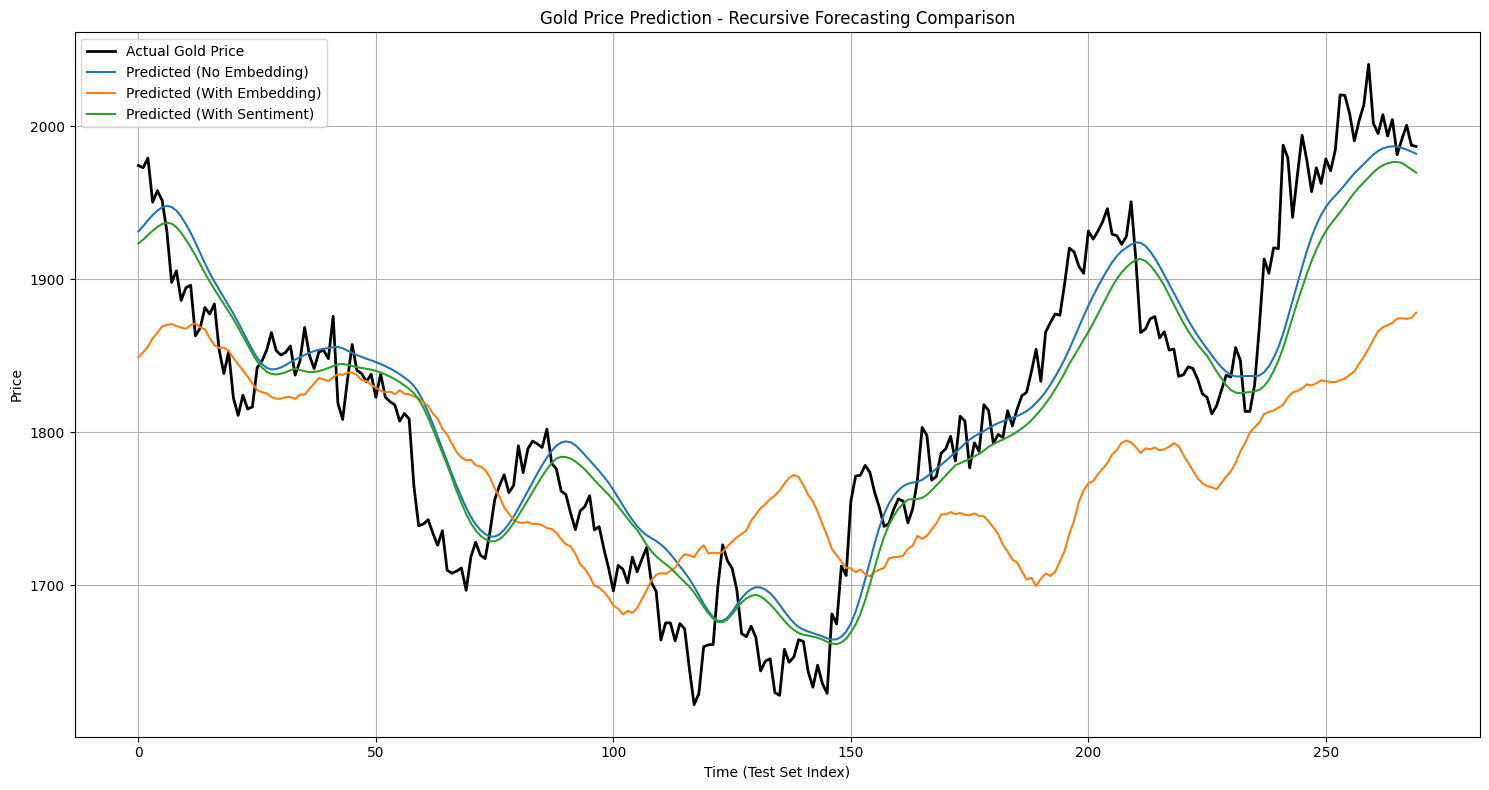

In [31]:
plot_length_recursive = len(y_test_actual_recursive)

plt.figure(figsize=(15, 8))
plt.plot(y_test_actual_recursive, color='black', label=f'Actual {title} Price', linewidth=2)

for model_name, preds in recursive_predictions.items():
    plt.plot(preds[:plot_length_recursive], label=f'Predicted ({model_name})')


plt.title(f'{title} Price Prediction - Recursive Forecasting Comparison')
plt.xlabel('Time (Test Set Index)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualization for Multi-output Prediction


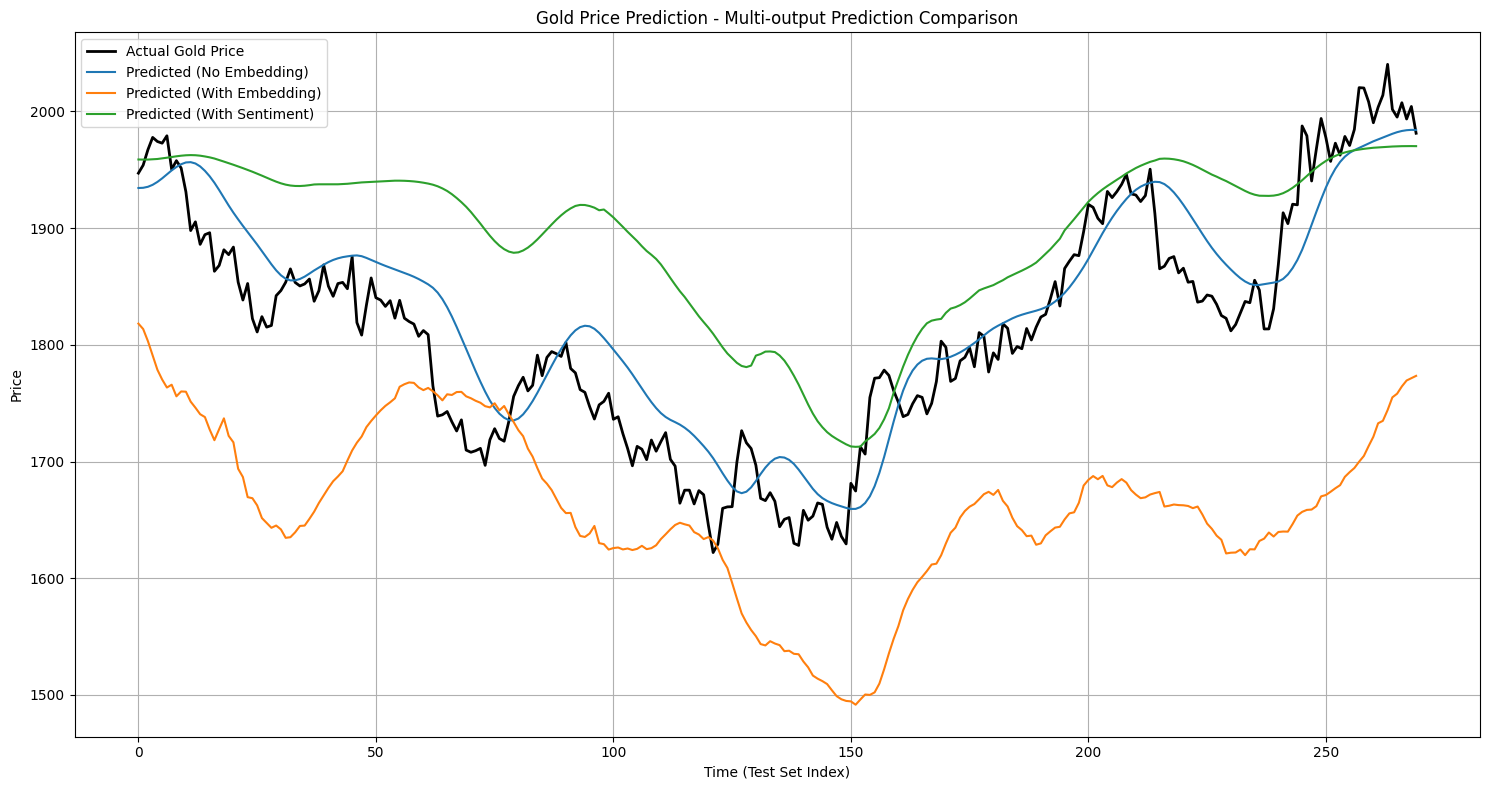

In [32]:
plot_length_multioutput = len(y_test_actual_multioutput)

plt.figure(figsize=(15, 8))
plt.plot(y_test_actual_multioutput, color='black', label=f'Actual {title} Price', linewidth=2)

for model_name, preds in multioutput_predictions.items():
    plt.plot(preds[:plot_length_multioutput], label=f'Predicted ({model_name})')


plt.title(f'{title} Price Prediction - Multi-output Prediction Comparison')
plt.xlabel('Time (Test Set Index)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Metrics comparison for Recursive Forecasting


Recursive Forecasting Model Performance Metrics on Gold price:
                        MSE       RMSE        MAE        DA
No Embedding    1450.537963  38.085929  31.462581  0.501859
With Embedding  7149.692276  84.555853  68.523155  0.520446
With Sentiment  1572.194956  39.650914  32.551534  0.501859


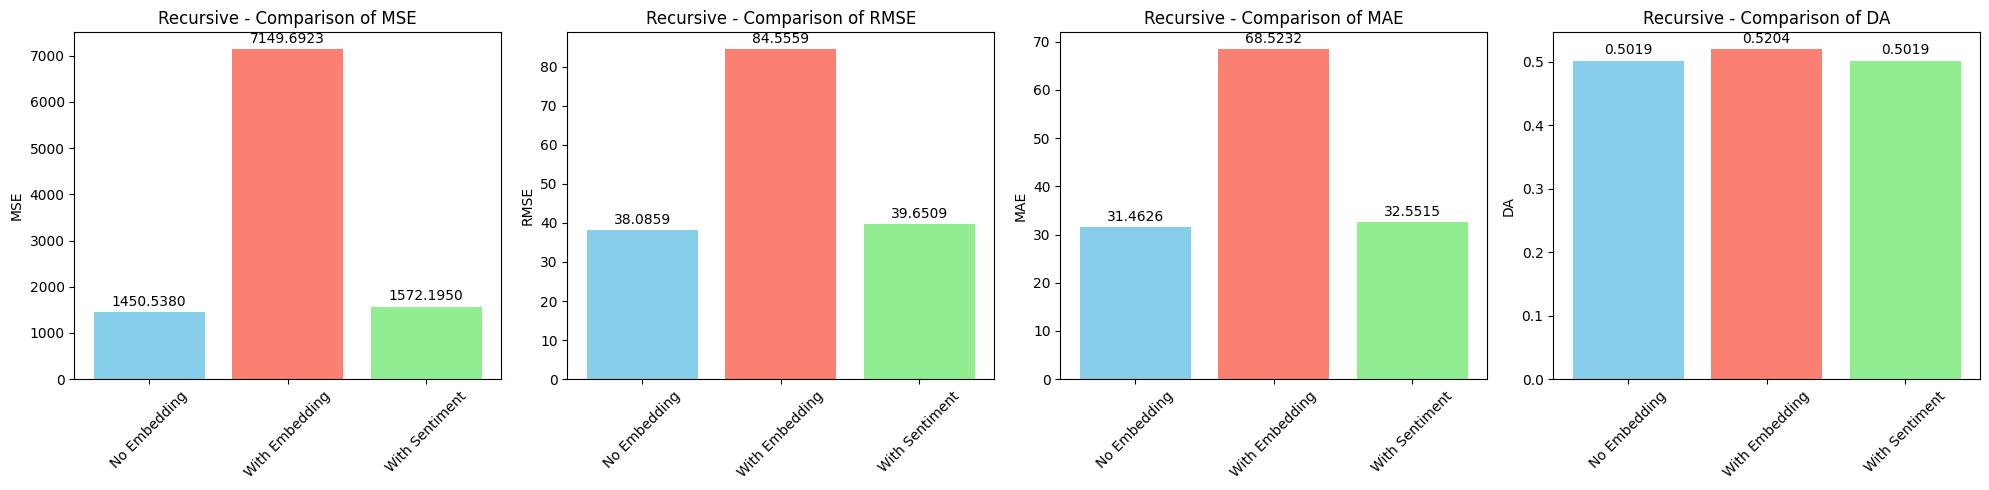

In [33]:
print(f"Recursive Forecasting Model Performance Metrics on {title} price:")
recursive_metrics_df = pd.DataFrame(recursive_results).T
print(recursive_metrics_df)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['MSE', 'RMSE', 'MAE', 'DA']
model_names = list(recursive_results.keys())

for i, metric in enumerate(metrics):
    values = [recursive_results[model][metric] for model in model_names]
    bars = axes[i].bar(model_names, values, color=['skyblue', 'salmon', 'lightgreen'])
    axes[i].set_title(f'Recursive - Comparison of {metric}')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(values)*0.01,
                        f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Metrics comparison for Multi-output Prediction



Multi-output Prediction Model Performance Metrics on Gold price:
                         MSE        RMSE         MAE        DA
No Embedding     1829.937286   42.777766   35.697567  0.494424
With Embedding  30437.295083  174.462876  156.784932  0.513011
With Sentiment  10604.710132  102.979173   87.293726  0.531599


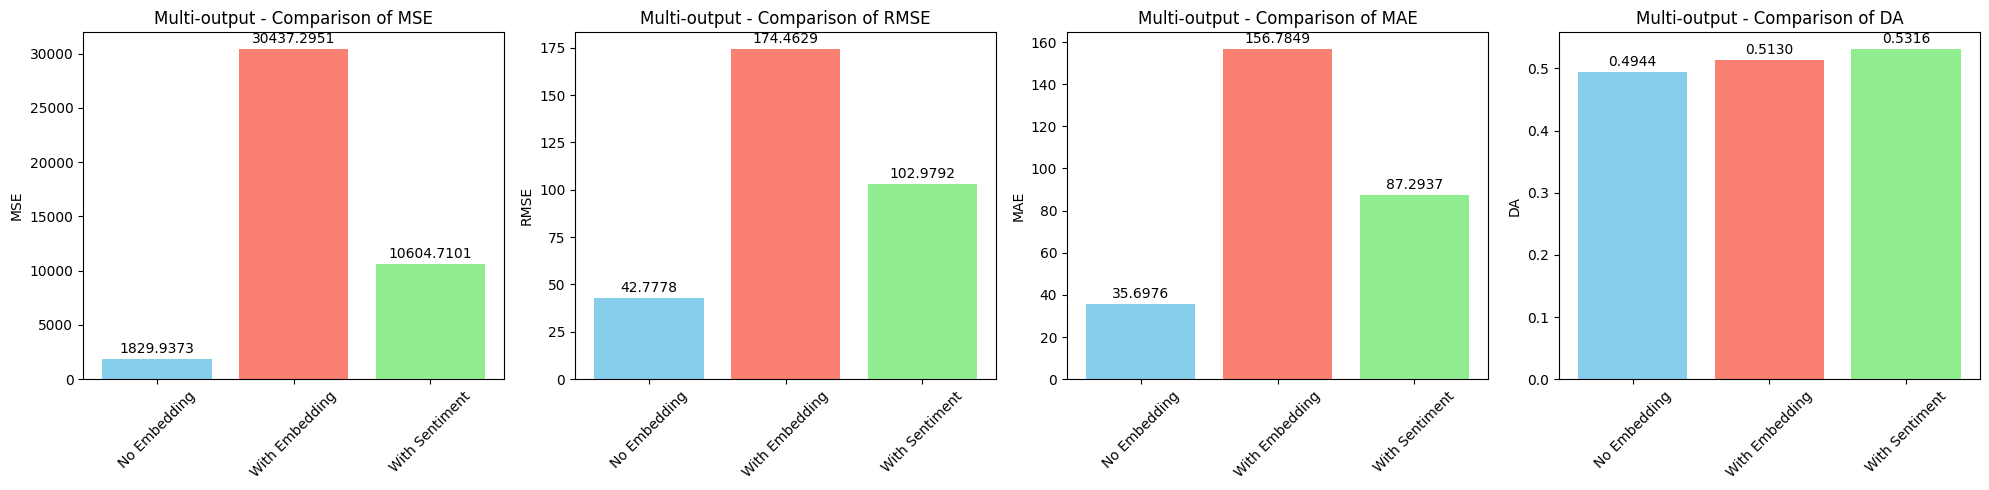

In [34]:
print(f"\nMulti-output Prediction Model Performance Metrics on {title} price:")
multioutput_metrics_df = pd.DataFrame(multioutput_results).T
print(multioutput_metrics_df)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['MSE', 'RMSE', 'MAE', 'DA']
model_names = list(multioutput_results.keys())

for i, metric in enumerate(metrics):
    values = [multioutput_results[model][metric] for model in model_names]
    bars = axes[i].bar(model_names, values, color=['skyblue', 'salmon', 'lightgreen'])
    axes[i].set_title(f'Multi-output - Comparison of {metric}')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(values)*0.01,
                        f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [35]:
def trading_strategy(predictions, actual_prices, initial_capital=100000):
    
    # Ensure arrays are same length
    min_length = min(len(predictions), len(actual_prices))
    predictions = predictions[:min_length]
    actual_prices = actual_prices[:min_length]
    
    # Initialize variables
    capital = initial_capital
    holdings = 0  # Number of units held
    transaction_log = []
    
    print(f"Starting capital: ${capital:,.2f}")
    print(f"Starting with {holdings} units")
    print("-" * 60)
    
    # Trading loop
    for i in range(len(predictions) - 1):
        current_price = actual_prices[i]
        predicted_next_price = predictions[i + 1] if i + 1 < len(predictions) else predictions[i]
        actual_next_price = actual_prices[i + 1] if i + 1 < len(actual_prices) else actual_prices[i]
        
        # Calculate expected return
        expected_return = predicted_next_price - current_price
        
        # Trading decision
        if expected_return > 0 and capital > 0:

            units_to_buy = capital // current_price
            if units_to_buy > 0:
                cost = units_to_buy * current_price
                capital -= cost
                holdings += units_to_buy
                transaction_log.append({
                    'day': i,
                    'action': 'BUY',
                    'price': current_price,
                    'units': units_to_buy,
                    'cost': cost,
                    'capital_after': capital,
                    'holdings_after': holdings
                })
                print(f"Day {i}: BUY {units_to_buy} units at ${current_price:.2f}")
                
        elif expected_return < 0 and holdings > 0:

            revenue = holdings * current_price
            capital += revenue
            transaction_log.append({
                'day': i,
                'action': 'SELL',
                'price': current_price,
                'units': holdings,
                'revenue': revenue,
                'capital_after': capital,
                'holdings_after': 0
            })
            print(f"Day {i}: SELL {holdings} units at ${current_price:.2f}")
            holdings = 0
        
        # Calculate current portfolio value
        portfolio_value = capital + (holdings * current_price)
        print(f"Day {i}: Portfolio Value: ${portfolio_value:,.2f} (Cash: ${capital:,.2f}, Holdings: {holdings} units)")
    
    # Final liquidation (sell all remaining holdings at last price)
    if holdings > 0:
        last_price = actual_prices[-1]
        final_revenue = holdings * last_price
        capital += final_revenue
        transaction_log.append({
            'day': len(predictions) - 1,
            'action': 'FINAL_LIQUIDATION',
            'price': last_price,
            'units': holdings,
            'revenue': final_revenue,
            'capital_after': capital,
            'holdings_after': 0
        })
        print(f"Final Day: LIQUIDATE {holdings} units at ${last_price:.2f}")
        holdings = 0
    
    # Calculate final results
    final_value = capital
    profit_loss = final_value - initial_capital
    roi = (profit_loss / initial_capital) * 100
    
    print("-" * 60)
    print(f"FINAL RESULTS:")
    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Value: ${final_value:,.2f}")
    print(f"Profit/Loss: ${profit_loss:,.2f}")
    print(f"Return on Investment: {roi:.2f}%")
    
    return {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'profit_loss': profit_loss,
        'roi': roi,
        'transactions': transaction_log,
        'final_holdings': holdings
    }


# Apply trading strategy to the best performing model


In [36]:
# Find the best performing model
best_model_name = None
best_rmse = float('inf')

for model_name, metrics in recursive_results.items():
    if metrics['RMSE'] < best_rmse:
        best_rmse = metrics['RMSE']
        best_model_name = model_name

print(f"Using best performing model: {best_model_name} (RMSE: {best_rmse:.4f})")

# Get predictions and actual prices for the best model
best_predictions = recursive_predictions[best_model_name]
best_actual_prices = y_test_actual_recursive

# Run trading strategy
trading_results = trading_strategy(best_predictions, best_actual_prices)


Using best performing model: No Embedding (RMSE: 38.0859)
Starting capital: $100,000.00
Starting with 0 units
------------------------------------------------------------
Day 0: Portfolio Value: $100,000.00 (Cash: $100,000.00, Holdings: 0 units)
Day 1: Portfolio Value: $100,000.00 (Cash: $100,000.00, Holdings: 0 units)
Day 2: Portfolio Value: $100,000.00 (Cash: $100,000.00, Holdings: 0 units)
Day 3: Portfolio Value: $100,000.00 (Cash: $100,000.00, Holdings: 0 units)
Day 4: Portfolio Value: $100,000.00 (Cash: $100,000.00, Holdings: 0 units)
Day 5: Portfolio Value: $100,000.00 (Cash: $100,000.00, Holdings: 0 units)
Day 6: BUY 51.0 units at $1931.09
Day 6: Portfolio Value: $100,000.00 (Cash: $1,514.41, Holdings: 51.0 units)
Day 7: Portfolio Value: $98,309.86 (Cash: $1,514.41, Holdings: 51.0 units)
Day 8: Portfolio Value: $98,692.36 (Cash: $1,514.41, Holdings: 51.0 units)
Day 9: Portfolio Value: $97,707.55 (Cash: $1,514.41, Holdings: 51.0 units)
Day 10: Portfolio Value: $98,130.34 (Cash: $

# Additional analysis


In [37]:
# Compare with buy-and-hold strategy
initial_price = best_actual_prices[0]
final_price = best_actual_prices[-1]
buy_hold_units = trading_results['initial_capital'] // initial_price
buy_hold_final_value = buy_hold_units * final_price
buy_hold_profit = buy_hold_final_value - trading_results['initial_capital']
buy_hold_roi = (buy_hold_profit / trading_results['initial_capital']) * 100

print(f"BUY-AND-HOLD STRATEGY COMPARISON:")
print(f"Initial Price: ${initial_price:.2f}")
print(f"Final Price: ${final_price:.2f}")
print(f"Units Purchased: {buy_hold_units}")
print(f"Final Value: ${buy_hold_final_value:,.2f}")
print(f"Profit/Loss: ${buy_hold_profit:,.2f}")
print(f"Return on Investment: {buy_hold_roi:.2f}%")

print(f"\nSTRATEGY COMPARISON:")
print(f"Trading Strategy ROI: {trading_results['roi']:.2f}%")
print(f"Buy-and-Hold ROI: {buy_hold_roi:.2f}%")
print(f"Difference: {trading_results['roi'] - buy_hold_roi:.2f}% points")

# Transaction summary
print(f"\nTRANSACTION SUMMARY:")
total_transactions = len([t for t in trading_results['transactions'] if t['action'] in ['BUY', 'SELL']])
print(f"Total Buy/Sell Transactions: {total_transactions}")
print(f"Final Holdings: {trading_results['final_holdings']} units")

BUY-AND-HOLD STRATEGY COMPARISON:
Initial Price: $1974.28
Final Price: $1986.75
Units Purchased: 50.0
Final Value: $99,337.50
Profit/Loss: $-662.50
Return on Investment: -0.66%

STRATEGY COMPARISON:
Trading Strategy ROI: 1.85%
Buy-and-Hold ROI: -0.66%
Difference: 2.51% points

TRANSACTION SUMMARY:
Total Buy/Sell Transactions: 33
Final Holdings: 0 units
